In [228]:

import pandas as pd 
import numpy as np 
from utils import * 
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from src.classifier import Classifier
import seaborn as sns 
import matplotlib.pyplot as plt
import glob
from src.files import InterProScanFile
import os
import dataframe_image as dfi
import warnings
warnings.simplefilter('ignore')

%load_ext autoreload
%autoreload 2

def save_table(df:pd.DataFrame, path:str=None):
    if path is None:
        return 
    elif path.split('.')[-1] == 'csv':
        df.to_csv(path)
    elif path.split('.')[-1] == 'png':
        dfi.export(df, path)
    return

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
test_results_df = pd.read_csv('../data/results/dataset_test_predict.csv', index_col=0)
test_results_df = test_results_df.merge(pd.read_csv('../data/datasets/dataset_test.csv', index_col=0), left_index=True, right_index=True, how='left')

train_results_df = pd.read_csv('../data/results/dataset_train_predict.csv', index_col=0)
train_results_df = train_results_df.merge(pd.read_csv('../data/datasets/dataset_train.csv', index_col=0), left_index=True, right_index=True, how='left')

In [217]:
results_df = pd.concat([train_results_df, test_results_df])
results_df['length'] = results_df.seq.apply(len)

In [6]:
def table_1(results_df:pd.DataFrame, path:str=None):

    model_names = [os.path.basename(path).replace('.pkl', '') for path in glob.glob('../models/*pkl')]

    table_df = list()
    for model_name in model_names:
        row = dict()
        row['model_name'] = model_name

        tn, fp, fn, tp = confusion_matrix(results_df['label'], results_df[f'{model_name}_label']).ravel()
        row['true_positive'] = tp
        row['true_negative'] = tn
        row['false_positive'] = fp
        row['false_negative'] = fn
        row['accuracy'] = np.round(balanced_accuracy_score(results_df.label, results_df[f'{model_name}_label']), 4)
        table_df.append(row)

    table_df = pd.DataFrame(table_df).set_index('model_name')
    table_df = table_df.sort_values('false_positive')

    # dfi.export(table_df, path, table_conversion='matplotlib')
    return table_df

table_1(results_df)


,true_positive,true_negative,false_positive,false_negative,accuracy
model_name,,,,,
model_v1,258505,17220,4,861,0.9982
model_v2,258833,17219,5,533,0.9988
model_v3,258915,17218,6,451,0.9990


In [7]:
model_name = 'model_v3'
train_results_df = train_results_df.rename(columns={col:col.replace(model_name, 'model') for col in train_results_df.columns})
test_results_df = test_results_df.rename(columns={col:col.replace(model_name, 'model') for col in test_results_df.columns})
results_df = results_df.rename(columns={col:col.replace(model_name, 'model') for col in results_df.columns})

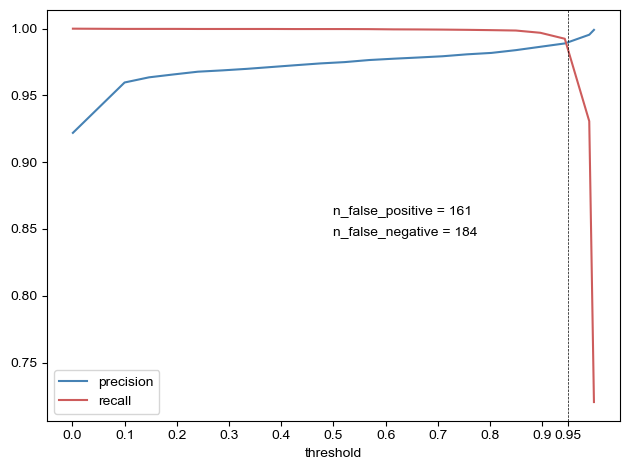

In [260]:
def figure(results_df, threshold:float=0.99):

    min_threshold = results_df.model_output_0.min() + 1e-3
    max_threshold = results_df.model_output_0.max() - 1e-3

    thresholds = [min_threshold] + list(np.linspace(0.1, 0.99, 20)) + [max_threshold]
    ax_df = pd.DataFrame(index=np.arange(len(thresholds)))
    ax_df['threshold'] = thresholds
    ax_df['precision'] = [precision(results_df, class_=0, threshold=threshold) for threshold in thresholds]
    ax_df['recall'] = [recall(results_df, class_=0, threshold=threshold) for threshold in thresholds]

    fig, ax = plt.subplots()

    sns.lineplot(data=ax_df, ax=ax, x='threshold', y='precision', label='precision', color='steelblue')
    sns.lineplot(data=ax_df, ax=ax, x='threshold', y='recall', label='recall', color='indianred')
    ax.axvline(threshold, color='black', linewidth=0.5, linestyle='--')

    n_fn = ((results_df.model_output_0 > threshold) & (results_df.label == 1)).sum()
    n_fp = ((results_df.model_output_0 <= threshold) & (results_df.label == 0)).sum()
    ax.text(0.5, 0.5, f'n_false_positive = {n_fp}', transform=ax.transAxes)
    ax.text(0.5, 0.45, f'n_false_negative = {n_fn}', transform=ax.transAxes)

    ax.set_ylabel('')
    x_ticks = sorted(list(np.arange(10) / 10) + [threshold])
    ax.set_xticks(x_ticks, labels=x_ticks)

    fig.tight_layout()
    plt.show()

figure(results_df, threshold=0.95)

In [218]:
threshold = 0.95
results_df['model_label'] = np.where(results_df.model_output_0 > threshold, 0, 1)

fp_results_df = results_df[(results_df.model_label == 1) & (results_df.label == 0)].copy()
fn_results_df = results_df[(results_df.model_label == 0) & (results_df.label == 1)].copy()

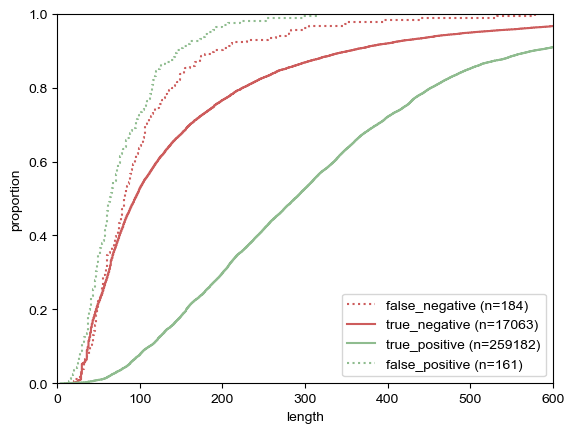

In [194]:
def figure(results_df):

    is_fn = lambda df : (df.model_label == 0) & (df.label == 1)
    is_tn = lambda df : (df.model_label == 0) & (df.label == 0)
    is_tp = lambda df : (df.model_label == 1) & (df.label == 1)
    is_fp = lambda df : (df.model_label == 1) & (df.label == 0)

    fig, ax = plt.subplots()

    ax_df = pd.DataFrame(index=results_df.index)
    ax_df['length'] = results_df.seq.apply(len)
    ax_df['false_negative'] = is_fn(results_df)
    ax_df['true_negative'] = is_tn(results_df)
    ax_df['true_positive'] = is_tp(results_df)
    ax_df['false_positive'] = is_fp(results_df)

    sns.ecdfplot(data=ax_df[ax_df.false_negative], x='length', color='indianred', linestyle=':', ax=ax, label=f'false_negative (n={ax_df.false_negative.sum()})')
    sns.ecdfplot(data=ax_df[ax_df.true_negative], x='length', color='indianred', ax=ax, label=f'true_negative (n={ax_df.true_negative.sum()})')
    sns.ecdfplot(data=ax_df[ax_df.true_positive], x='length', color='darkseagreen', ax=ax, label=f'true_positive (n={ax_df.true_positive.sum()})')
    sns.ecdfplot(data=ax_df[ax_df.false_positive], x='length', color='darkseagreen', linestyle=':', ax=ax, label=f'false_positive (n={ax_df.false_positive.sum()})')
    ax.legend()
    ax.set_xlim(xmin=0, xmax=600)
    ax.set_ylabel('proportion')
    plt.show()

figure(results_df)


In [195]:
def get_nearest_spurious_cluster_rank(results_df, n:int=10):
    ranks = list()
    for row in results_df.itertuples():
        for rank in range(2, n):
            if getattr(row, f'rank_{rank}_cluster_label') == 0:
                ranks.append(rank)
                break
            if rank == (n - 1):
                ranks.append(None)
    results_df['nearest_spurious_cluster_rank'] = ranks
    return results_df

In [219]:
cluster_metadata_df = pd.read_csv('../data/datasets/dataset_cluster_metadata.csv', index_col=0)
fn_cluster_predict_df = pd.read_csv('../data/results/dataset_fn_cluster_predict.csv', index_col=0).loc[fn_results_df.index]

assert np.all(fn_results_df.index == fn_cluster_predict_df.index), 'The indices of the results and cluster predictions do not match.'
assert np.all(fn_cluster_predict_df.top_cluster_id == fn_results_df.cluster_id), 'The cluster predictions do not match the assigned cluster IDs.'

fn_results_df = fn_results_df.merge(fn_cluster_predict_df, left_index=True, right_index=True, validate='one_to_one')
fn_results_df = fn_results_df.merge(cluster_metadata_df, left_on='cluster_id', right_index=True, how='left')
fn_results_df = get_nearest_spurious_cluster_rank(fn_results_df)

In [259]:
def get_cluster_model_output_info(results_df:pd.DataFrame) -> pd.DataFrame:

    cluster_metadata_df = list()
    for cluster_id, df in results_df.groupby('cluster_id'):
        cluster_label = df.label.values[0]
        model_output = df.model_output_0 if (cluster_label == 0) else df.model_output_1
        row = {'cluster_id':cluster_id}
        row['cluster_model_output_delta'] = model_output.max() - model_output.min()
        row['cluster_model_output_mean'] = model_output.mean()
        row['cluster_n_false_negative'] = ((df.label == 1) & (df.model_label == 0)).sum()
        row['cluster_n_false_positive'] = ((df.label == 0) & (df.model_label == 1)).sum()
        cluster_metadata_df.append(row)

    cluster_metadata_df = pd.DataFrame(cluster_metadata_df).set_index('cluster_id')
    results_df = results_df.drop(columns=cluster_metadata_df.columns, errors='ignore') # Make sure not to end up with duplicate columns. 
    results_df = results_df.merge(cluster_metadata_df, left_on='cluster_id', right_index=True, how='left')
    return results_df

results_df = get_cluster_model_output_info(results_df)

<Axes: xlabel='cluster_radius', ylabel='model_output_delta'>

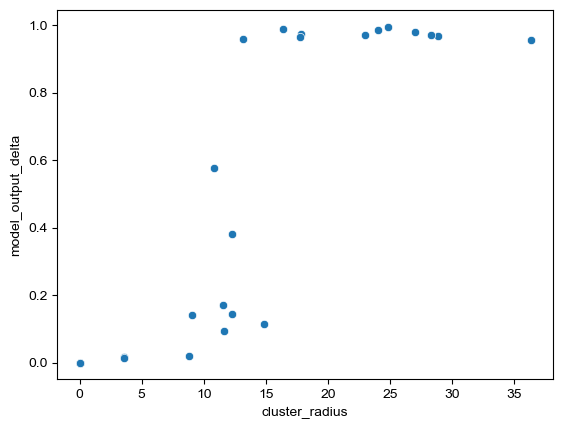

In [176]:

sns.scatterplot(data=cluster_metadata_df[cluster_metadata_df.n_false_negative > 0], y='model_output_delta', x='cluster_radius')
# sns.scatterplot(data=cluster_metadata_df[cluster_metadata_df.n_false_positive > 0], y='model_output_delta', x='intra_cluster_max_distance')

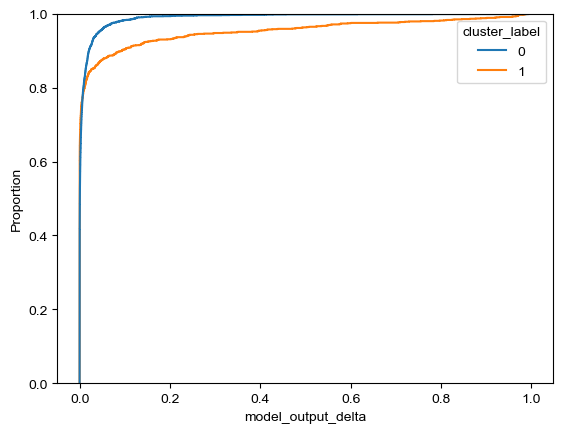

In [ ]:
# How consistently does the model perform on sequences in the same cluster?
def figure(cluster_metadata_df):

    fig, ax = plt.subplots()
    palette = {0:'indianred', 1:'darkseagreen'}
    sns.ecdfplot(ax=ax, data=ax_df, x='model_output_delta', palette=palette, hue='cluster_label')

    plt.show()
    return ax_df 

df = figure(results_df)



In [ ]:
# Should treat the false negatives in chunks: The singleton and non-singleton false negatives. 
def table(results_df:pd.DataFrame, path:str=None, singleton:bool=True):

    if singleton:
        results_df = results_df[results_df.cluster_size == 1].copy()
        nearest_cluster = 'rank_2_cluster'
    else:
        results_df = results_df[results_df.cluster_size > 1].copy()
        nearest_cluster = 'top_cluster'

    def get_nearest_spurious_cluster_info(field:str='id'):
        return [getattr(row, f'rank_{row.nearest_spurious_cluster_rank}_cluster_{field}') for row in results_df.itertuples()]

    table_df = pd.DataFrame(index=results_df.index) # Get the mis-predicted singleton clusters. 
    table_df['product'] = results_df['product']
    table_df['length'] = results_df.seq.apply(len)
    table_df['nearest_spurious_cluster_id'] = get_nearest_spurious_cluster_info(field='id')
    table_df['nearest_spurious_cluster_distance'] = get_nearest_spurious_cluster_info(field='distance')
    table_df['nearest_cluster_id'] = results_df[f'{nearest_cluster}_id']
    table_df['nearest_cluster_distance'] = results_df[f'{nearest_cluster}_distance']

    save_table(table_df, path)
    return table_df.sort_values('length')

table(fn_results_df, singleton=True, path='../data/figures/results-table_2_singleton.csv')
table(fn_results_df, singleton=False, path='../data/figures/results-table_2_non_singleton.csv')

In [251]:
fn_results_df[fn_results_df.cluster_size != 1][['product', 'length']]
results_df[results_df.cluster_id == 3236][['product', 'length', 'antifam_id', 'antifam_description', 'model_output_0']]

,product,length,antifam_id,antifam_description,model_output_0
id,,,,,
A0A2N7QST9,Uncharacterized protein,60,ANF00178,Shadow ORF (opposite dhbF),0.939821
A0A9Q4A9W2,DUF1534 domain-containing protein,28,ANF00261,Protein of unknown function (DUF1534),0.982843


In [234]:
cluster_metadata_df.loc[34644]

n_aligned                        4.000000
frac_aligned                     0.088889
mean_sequence_identity           0.457750
min_sequence_identity            0.295000
max_sequence_identity            0.747000
cluster_size                    10.000000
cluster_label                    0.000000
cluster_radius                  14.359375
intra_cluster_max_distance      22.531250
intra_cluster_min_distance      14.054688
intra_cluster_mean_distance     17.796875
inter_cluster_max_distance     122.560000
inter_cluster_min_distance      10.300000
inter_cluster_mean_distance     57.940000
Name: 34644, dtype: float64

In [62]:
def get_cluster_annotations(results_df:pd.DataFrame, cluster_ids:list=None, annotation_col:str='product'):
    annotations = dict()
    if cluster_ids is not None:
        results_df = results_df[results_df.cluster_id.isin(cluster_ids)]
        
    for cluster_id, df in results_df.groupby('cluster_id'):
        # is_uncharacterized = [('uncharacterized' in product.lower()) for product in products]
        # products = np.where(is_uncharacterized, 'Uncharacterized protein', products)
        annotations[cluster_id] = ';'.join(np.unique(df[annotation_col].values ))
    return annotations


In [33]:
# fp_cluster_metadata_df = pd.DataFrame(index=pd.Index(fp_cluster_ids, name='cluster_id'))
# fp_cluster_metadata_df['size'] = fp_cluster_df.groupby('cluster_id').apply(len, include_groups=False)
# fp_cluster_metadata_df['n_errors'] = fp_results_df.groupby('cluster_id').apply(len, include_groups=False)
# fp_cluster_metadata_df['frac_errors'] = fp_cluster_metadata_df.n_errors / fp_cluster_metadata_df['size']

fn_cluster_metadata_df = pd.DataFrame(index=pd.Index(fn_cluster_ids, name='cluster_id'))
fn_cluster_metadata_df['size'] = fn_cluster_df.groupby('cluster_id').apply(len, include_groups=False)
fn_cluster_metadata_df['n_errors'] = fn_results_df.groupby('cluster_id').apply(len, include_groups=False)
fn_cluster_metadata_df['frac_errors'] = fn_cluster_metadata_df.n_errors / fn_cluster_metadata_df['size']



In [52]:
fn_cluster_metadata_df[fn_cluster_metadata_df['size'] == 1]

,size,n_errors,frac_errors
cluster_id,,,
1634,1,1,1.0
1919,1,1,1.0
3451,1,1,1.0
2747,1,1,1.0
2424,1,1,1.0
...,...,...,...
3611,1,1,1.0
1805,1,1,1.0
3586,1,1,1.0


In [72]:
fn_results_df.columns

Index(['model_label', 'model_output_0', 'model_output_1', 'model_v2_label',
       'model_v2_output_0', 'model_v2_output_1', 'model_v1_label',
       'model_v1_output_0', 'model_v1_output_1', 'domain', 'lineage',
       'ncbi_taxonomy_id', 'refseq_protein_id', 'refseq_nucleotide_id',
       'non_terminal_residue', 'function', 'post_translational_modification',
       'pfam_description', 'pfam_id', 'interpro_description', 'interpro_id',
       'ncbifam_description', 'ncbifam_id', 'panther_description',
       'panther_id', 'supfam_description', 'supfam_id', 'gene3d_description',
       'gene3d_id', 'kegg_description', 'kegg_id', 'go_description', 'go_id',
       'antifam_description', 'antifam_id', 'product', 'seq', 'existence',
       'name', 'file_name', 'library_entry_name', 'label', 'phylum', 'class',
       'order', 'family', 'genus', 'species', 'cluster_id', 'length'],
      dtype='object')

In [86]:
fn_results_df['length'] = fn_results_df.seq.apply(len)
fn_results_df[['product', 'cluster_id', 'length', 'function', 'existence', 'library_entry_name']].sort_values('existence').to_csv('../data/results/dataset_fn.csv')

In [80]:
results_df[results_df.existence == 'uncertain'].sort_values('model_output_0')

,model_label,model_output_0,model_output_1,model_v2_label,model_v2_output_0,model_v2_output_1,model_v1_label,model_v1_output_0,model_v1_output_1,domain,...,file_name,library_entry_name,label,phylum,class,order,family,genus,species,cluster_id
id,,,,,,,,,,,,,,,,,,,,,
P0C1B9,1,0.000000e+00,1.000000,1,6.039027e-33,1.000000,1,3.303444e-11,1.000000,Bacteria,...,swissprot.xml,swissprot_bacteria,1,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Shigella,Shigella boydii,39005
P0C184,1,7.942437e-37,1.000000,1,6.020139e-27,1.000000,1,2.278764e-11,1.000000,Bacteria,...,swissprot.xml,swissprot_bacteria,1,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Shigella,Shigella sonnei,24881
P39369,1,3.986471e-33,1.000000,1,4.839284e-23,1.000000,1,3.791264e-10,1.000000,Bacteria,...,swissprot.xml,swissprot_bacteria,1,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Escherichia,Escherichia coli,46011
Q8Z6Q3,1,2.286577e-32,1.000000,1,9.610166e-22,1.000000,1,9.278859e-09,1.000000,Bacteria,...,swissprot.xml,swissprot_bacteria,1,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Salmonella,Salmonella enterica,38307
P0DP89,1,7.571896e-32,1.000000,1,2.780391e-21,1.000000,1,9.832970e-09,1.000000,Bacteria,...,swissprot.xml,swissprot_bacteria,1,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Escherichia,Escherichia coli,31344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P20343,0,9.921295e-01,0.007871,0,9.311152e-01,0.068885,0,9.950204e-01,0.004980,Bacteria,...,swissprot.xml,swissprot_bacteria,1,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Escherichia,Escherichia coli,2613
P55536,0,9.934612e-01,0.006539,0,9.912775e-01,0.008723,0,9.870935e-01,0.012906,Bacteria,...,swissprot.xml,swissprot_bacteria,1,Pseudomonadota,Alphaproteobacteria,Hyphomicrobiales,Rhizobiaceae,Sinorhizobium,Sinorhizobium fredii,3010
Q8X6E3,0,9.939371e-01,0.006063,0,9.942474e-01,0.005752,0,9.963814e-01,0.003619,Bacteria,...,swissprot.xml,swissprot_bacteria,1,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Escherichia,Escherichia coli,2645


In [ ]:
results_df[results_df.cluster_id == 33031][['ncbifam_description']]

,ncbifam_description
id,
Q02541,cztS_silS_copS
Q748D9,none
I1WSZ3,cztS_silS_copS
P0DMK6,cztS_silS_copS
Q9ZHD4,cztS_silS_copS
Q44007,cztS_silS_copS
Q8X614,none
P14377,none
P33951,cyc_pep_trnsptr


In [ ]:
results_df.columns

Index(['model_label', 'model_output_0', 'model_output_1', 'model_v2_label',
       'model_v2_output_0', 'model_v2_output_1', 'model_v1_label',
       'model_v1_output_0', 'model_v1_output_1', 'cluster_id', 'antifam_name',
       'antifam_id', 'product', 'ncbi_taxonomy_id', 'organism', 'seq',
       'lineage', 'library_entry_name', 'label', 'refseq_protein_id',
       'refseq_nucleotide_id', 'non_terminal_residue', 'function',
       'post_translational_modification', 'pfam_description', 'pfam_id',
       'interpro_description', 'interpro_id', 'ncbifam_description',
       'ncbifam_id', 'panther_description', 'panther_id', 'supfam_description',
       'supfam_id', 'gene3d_description', 'gene3d_id', 'kegg_description',
       'kegg_id', 'existence', 'name', 'file_name', 'domain', 'phylum',
       'class', 'order', 'family', 'genus', 'species'],
      dtype='object')

In [ ]:
def annotate_clusters(results_df:pd.DataFrame):
    annotations = dict()
    for cluster_id, df in results_df.groupby('cluster_id'):
        # cluster_annotations = df['product'].replace({'Uncharacterized protein':'none'}).unique()
        cluster_annotations = df['product'].apply(lambda product : 'Uncharacterized protein' if ('uncharacterized' in product.lower()) else product)
        cluster_annotations = np.unique(cluster_annotations)
        cluster_annotations = ','.join(list(cluster_annotations))
        annotations[cluster_id] = cluster_annotations 
    return pd.Series(annotations)

In [ ]:
annotate_clusters(results_df)

0        none
1        none
2        none
3        none
4        none
         ... 
49995    none
49996    none
49997    none
49998    none
49999    none
Length: 50000, dtype: object

In [ ]:
# What are the proteins it struggles on?

# def figure(results_df:pd.DataFrame, threshold:float=0.95):

#     results_df = results_df.copy()

#     fig, ax = plt.subplots()

#     # sns.kdeplot(ax=ax, data=results_df[results_df.model_label == 1].seq.apply(len))
#     # sns.kdeplot(ax=ax, data=results_df[results_df.model_label == 0].seq.apply(len))
#     # sns.kdeplot(ax=ax, data=fp_results_df.seq.apply(len))
#     # sns.kdeplot(ax=ax, data=fn_results_df.seq.apply(len))

#     plt.show()

#     return fp_results_df, fn_results_df



In [ ]:
fn_results_df.seq.apply(len).mean()
fp_results_df.seq.apply(len).mean()

np.float64(95.22222222222223)

In [ ]:
results_df.seq.apply(len).mean()

np.float64(315.1821862784161)

In [ ]:
results_df[results_df.label == 0].seq.apply(len).mean()

np.float64(166.97018525170625)

In [ ]:
fp_results_df

,model_label,model_output_0,model_output_1,model_v2_label,model_v2_output_0,model_v2_output_1,model_v1_label,model_v1_output_0,model_v1_output_1,antifam_name,...,kegg,file_name,domain,phylum,class,order,family,genus,species,cluster_id
id,,,,,,,,,,,,,,,,,,,,,
A0A2H6ADC5,1,0.943531,0.056469,0,0.977635,0.022365,0,0.986667,0.013333,Shadow ORF (opposite leuS),...,none,none,Bacteria,none,none,none,none,none,bacterium HR36,29433
A0A0H3B5W2,1,0.949893,0.050107,0,0.955236,0.044764,0,0.973400,0.026600,Translation of DNA tandem repeat,...,none,none,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Yersiniaceae,Yersinia,Yersinia pseudotuberculosis,39708
A0A857F6C1,1,0.936801,0.063199,0,0.937762,0.062238,0,0.948728,0.051272,Protein of unknown function (DUF2575),...,none,none,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Yersiniaceae,Yersinia,Yersinia canariae,2913
A0A8B3JQU5,1,0.939838,0.060162,0,0.935253,0.064748,0,0.938695,0.061305,Protein of unknown function (DUF2575),...,none,none,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Enterobacter,Enterobacter sp. WCHEn090032,1338
A0A1B2YQK5,1,0.848133,0.151867,0,0.965499,0.034501,0,0.963528,0.036472,Antisense to 23S rRNA,...,none,none,Bacteria,none,none,none,none,none,uncultured bacterium,3777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A0A1I5C0G0,1,0.932525,0.067475,0,0.972814,0.027186,0,0.977199,0.022801,Shadow ORF (opposite ABC transporters),...,none,none,Bacteria,Pseudomonadota,Alphaproteobacteria,Hyphomicrobiales,Nitrobacteraceae,Bradyrhizobium,Bradyrhizobium sp. Rc3b,4963
I1ZKU7,1,0.940282,0.059718,0,0.926827,0.073173,0,0.982894,0.017106,Shadow ORF (opposite ABC transporter protein),...,none,none,Bacteria,Bacillota,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,Streptococcus parasanguinis,4141
A0A2N9MKG5,1,0.779071,0.220929,0,0.871251,0.128749,0,0.941939,0.058061,tRNA translation,...,none,none,Bacteria,Acidobacteriota,Terriglobia,Bryobacterales,Solibacteraceae,Candidatus Sulfopaludibacter,Candidatus Sulfopaludibacter sp. SbA6,2622
